In [1]:
import findspark

In [2]:
findspark.init('/home/caio/spark-2.1.0-bin-hadoop2.7/')

In [271]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql import types as t
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [363]:
import pandas as pd
import numpy as np

In [6]:
pdf = pd.read_csv('./titanic/train.csv')

In [8]:
target = 'Survived'

In [9]:
spark = SparkSession.builder.appName('TestingMLlib').getOrCreate()

In [17]:
df = spark.read.csv('./titanic/train.csv',header=True)

In [26]:
converter = {'int64':t.IntegerType(),'float64':t.FloatType(),'object':t.StringType()}

In [43]:
schema = t.StructType([t.StructField(c,converter[str(i[0])],False) for c, i in pdf.dtypes.to_frame().iterrows()])

In [371]:
df = spark.createDataFrame(pdf, schema=schema)

In [372]:
cat_cols = [col for col, col_type in df.dtypes if col_type=='string']
num_cols = list(set(df.columns) - set(cat_cols) - set(target))
num_cols.remove('Survived')
num_cols.remove('PassengerId')

In [373]:
df = df.fillna('NA', subset=cat_cols)
df = df.fillna(0, subset=num_cols)

In [374]:
vec = VectorAssembler(inputCols=num_cols, outputCol='features')
df = vec.transform(df)

df = df[['features', target]]

In [375]:
train, test = df.randomSplit([0.9, 0.1], seed=1)

In [376]:
rf = RandomForestClassifier(featuresCol='features',
                             labelCol=target,
                             seed=42
                            )

In [377]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 300, 700, 1000]) \
    .addGrid(rf.maxDepth, [3, 5, 8, 10]) \
    .build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol=target),
                          numFolds=2)  # use 3+ folds in practice

cvModel = crossval.fit(train)

In [378]:
pred = cvModel.transform(test)

In [379]:
def get_positives(probs):
    pos = probs.values[1]
    return float(pos)

In [380]:
get_pos_udf = f.udf(get_positives, t.FloatType())

In [381]:
pred.select('PassengerId',get_pos_udf('probability').alias('positives')).show()

+-----------+----------+
|PassengerId| positives|
+-----------+----------+
|          5|0.14419843|
|         21|0.47176743|
|         33| 0.2927766|
|         37|0.23926449|
|         39|0.34393007|
|         49|0.43011567|
|        102| 0.1644633|
|        104|0.21015829|
|        106|0.16574399|
|        114|0.24653836|
|        118| 0.4656982|
|        121|0.46302533|
|        130|0.06235711|
|        136|0.43917078|
|        137|0.75129414|
|        143|0.29633635|
|        144|0.20726404|
|        147| 0.2177845|
|        164|0.21072105|
|        217|0.19525267|
+-----------+----------+
only showing top 20 rows



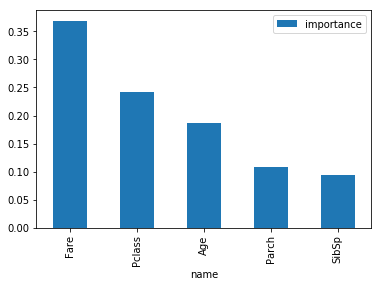

In [382]:
feature = pd.DataFrame(cvModel.bestModel.featureImportances.toArray(), columns=['importance'])
feature['name'] = num_cols
_ = feature.set_index('name').sort_values(by='importance',ascending=False).plot.bar()

### ROC AUC on Training Set for best model:

In [383]:
np.max(cvModel.avgMetrics)

0.7639870868743741

### ROC AUC on Test Set for best model:

In [385]:
cvModel.getEvaluator().evaluate(pred,{cvModel.getEvaluator().metricName: 'areaUnderROC'})

0.742

### ROC PR on Test Set for best model:

In [384]:
cvModel.getEvaluator().evaluate(pred,{cvModel.getEvaluator().metricName: 'areaUnderPR'})

0.7074846580211005